In [1]:
from oil.datasetup.datasets import split_dataset
from oil.utils.utils import FixedNumpySeed
import pytorch_lightning as pl

import torch
from torch.utils.data import DataLoader
from torch import Tensor
from biases.systems.chain_pendulum import ChainPendulum
from biases.systems.magnet_pendulum import MagnetPendulum


class DynamicsModel(pl.LightningModule):
    def __init__(
        self,
        network,
        dataset,
        lr: float,
        n_train: int,
        n_val: int,
        n_test: int,
        batch_size: int,
        angular: bool,
        body=ChainPendulum(3),
        chunk_len: int = 5,
        dt: float = 0.1,
        integration_time: float = 10.0,
        net_cfg: dict = {},
        regen: bool = False,
        seed: int = 0,
    ):
        super().__init__()
        splits = {"train": n_train, "val": n_val, "test": n_test}
        dataset = dataset(
            n_systems=n_train + n_val + n_test,
            regen=regen,
            chunk_len=chunk_len,
            body=body,
            dt=dt,
            integration_time=integration_time,
            angular_coords="Pendulum" in type(body),
        )

        with FixedNumpySeed(seed):
            self.datasets = split_dataset(dataset, splits)
        self.splits = splits

        self.batch_sizes = splits
        self.batch_sizes["train"] = batch_size

        self.lr = lr

        self.model = network(G=dataset.body.body_graph, angular_dims=angular, **net_cfg)

    def forward(self):
        raise RuntimeError("This module should not be called")
        
    def loss(self, batch):
        tol = 1e-4

        (z0, ts), true_zs = batch

        pred_zs = self.model.integrate(z0, ts[0], tol=tol)
        
        # TODO: annotate the shape of true_zs
        return (pred_zs - true_zs).pow(2).mean()

    def training_step(self, batch: Tensor, batch_idx: int):
        loss = self.loss(batch)
        logs = {"metrics/mse_averaged_over_time": loss.detach()}
        return {
            "loss": loss,
            "log": logs,
        }
    
    def validation_step(self, batch, batch_idx):
        loss = self.loss(batch)
        return {"val_metrics/mse_averaged_over_time": loss}
    
    
    def test_step(self, batch, batch_idx):
        # TODO: how to pass arguments from Trainer.test to here?
        loss = self.loss(batch)
        return {"test_metrics/mse_averaged_over_time": loss}
    
    def test_end(self, outputs):
        def _collect(field):
            return torch.cat([log[field] for log in outputs], dim=0)
        outputs = {field: _collect(field) for field in outputs[0].keys()}
        self.test_outputs = outputs
        
        log = {}
        
        # TODO: how to make this print in TQDM bar? Maybe bug.
        #print(log)
        return {"progress_bar": log, "log": log}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def train_dataloader(self):
        return DataLoader(
            self.datasets["train"],
            batch_size=self.batch_sizes["train"],
            pin_memory=torch.cuda.is_available(),
            num_workers=0,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.datasets["val"],
            batch_size=self.batch_sizes["val"],
            pin_memory=torch.cuda.is_available(),
            num_workers=0,
            shuffle=False,
        )

    def test_dataloader(self):
        return DataLoader(
            self.datasets["test"],
            batch_size=self.batch_sizes["test"],
            pin_memory=torch.cuda.is_available(),
            num_workers=0,
            shuffle=False,
        )

In [2]:
from biases.models.lnn import LNN
from biases.models.hnn import HNN
from biases.models.nn import NN, DeltaNN
from biases.models.constrained_nn import CHNN
from biases.datasets import RigidBodyDataset
from pytorch_lightning import Trainer
from pytorch_lightning.logging import TensorBoardLogger
import matplotlib.pyplot as plt

max_epochs = 500
n_gpus = 1

trainer = Trainer(max_epochs=max_epochs, gpus=n_gpus, check_val_every_n_epoch=50)
dynamics_model = DynamicsModel(CHNN, RigidBodyDataset,
                               lr=1e-3,
                               n_train=800,
                               n_val=100,
                               n_test=100,
                               batch_size=200,
                               angular=tuple(),
                               regen=False)

INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0


tensor(0.0012, dtype=torch.float64)
CH does not use angular_dims
CH currently assumes potential energy depends only on q
CH currently assumes time independent Hamiltonian
CH assumes positions q are in Cartesian coordinates


In [3]:
trainer.fit(dynamics_model)

/mnt/storage1/Documents/repos/pytorch-lightning/pytorch_lightning/utilities/warnings.py:18: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
/mnt/storage1/Documents/repos/pytorch-lightning/pytorch_lightning/utilities/warnings.py:18: RuntimeWarning: You have defined a `test_dataloader()` and have defined a `test_step()`, you may also want to define `test_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
INFO:lightning:
   | Name                    | Type       | Params
---------------------------------------------------
0  | model                   | CHNN       | 82 K  
1  | model.potential_net     | Sequential | 82 K  
2  | model.potential_net.0   | Sequential | 1 K   
3  | model.potential_net.0.0 | Linear     | 1 K   
4  | model.potential_net.0.1 | Tanh       | 0     
5  | model.potential_net.1   | Sequential | 4

AssertionError: 

In [4]:
%debug

> /mnt/storage1/Documents/repos/hamiltonian-biases/biases/models/constrained_nn.py(111)integrate()
    109         """
    110         assert (z0.ndim == 4) and (ts.ndim == 1)
--> 111         assert z0.size(-1) == self.dof_ndim
    112         assert z0.size(-2) == self.n_dof
    113         N = z0.size(0)



ipdb>  self.dof_ndim


2


ipdb>  z0.size()


torch.Size([100, 2, 3, 1])


ipdb>  q


In [8]:
torch.solve(torch.randn(5, 2, 1), torch.randn(5, 2, 2))

torch.return_types.solve(
solution=tensor([[[ -0.4620],
         [  0.9398]],

        [[ -4.1393],
         [-20.1343]],

        [[  1.0373],
         [  0.2798]],

        [[ -0.0932],
         [  0.8853]],

        [[ -0.4430],
         [  3.3343]]]),
LU=tensor([[[-1.1974,  0.6369],
         [-0.1464, -1.0871]],

        [[-2.2406,  0.5303],
         [-0.4840,  0.0556]],

        [[-0.5673,  0.3907],
         [-0.7909, -0.4647]],

        [[-2.0094, -0.4833],
         [-0.6115,  1.3766]],

        [[-1.5443, -0.5014],
         [-0.2771, -0.3755]]]))

In [3]:
Ts = dynamics_model.train_dataloader().dataset.Ts
Zs = dynamics_model.train_dataloader().dataset.Zs

In [4]:
Zs.shape

torch.Size([1000, 5, 2, 1, 1])

In [5]:
Zs = Zs.reshape(Zs.shape[:3])

In [6]:
q = Zs[:, :, 0]
qdot = Zs[:, :, 1]

from biases.models.utils import mod_angles
q_mod = mod_angles(q.reshape(-1, 1), (0,)).reshape(Zs.shape[:2])

> /mnt/storage1/Documents/repos/hamiltonian-biases/biases/models/utils.py(37)mod_angles()
     35     assert q.ndim == 2
     36     breakpoint()
---> 37     D = q.size(-1)
     38     non_angular_dims = list(set(range(D)) - set(angular_dims))
     39     q_modded_dims = (q[..., angular_dims] + math.pi) % (2 * math.pi) - math.pi



ipdb>  c


In [7]:
q = q.cpu().numpy()
qdot = qdot.cpu().numpy()
q_mod = q_mod.cpu().numpy()

(-5.649296832084656, 82.87936933040619, -3.6987446904182435, 3.436630880832672)

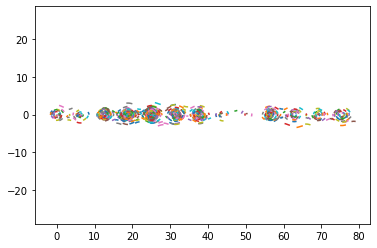

In [8]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.plot(q.T, qdot.T);
ax.axis("equal")

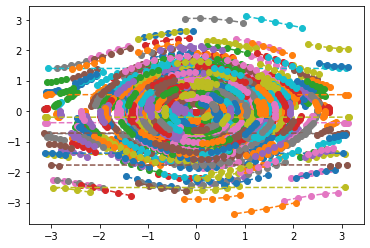

In [10]:
fig, ax = plt.subplots()
ax.plot(q_mod.T, qdot.T, '--o');

In [31]:
from biases.dynamics.lagrangian import LagrangianDynamics

model = LagrangianDynamics(lambda t, z: z * z)


N, D = 100, 6

t = torch.randn(1).squeeze(0)
z = torch.randn((N, D))

z.shape == model(t, z).shape

True